## Attempt 2 at Image Processing Code that can replicate results from the papers

### The key this time is to use an interpolation step, so that we have evenly spaced points spread over the domain

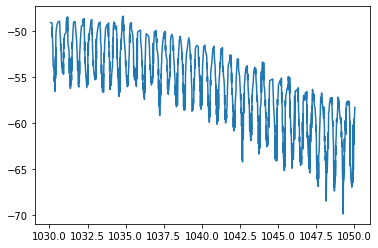

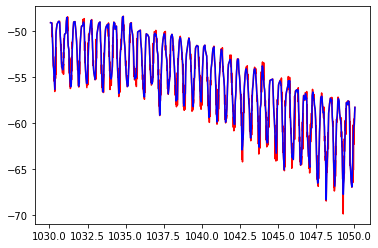

[[1030.071503    -49.06519561]
 [1030.11151307  -49.08411661]
 [1030.15152314  -49.10303761]
 [1030.19153321  -50.44122759]
 [1030.23154328  -52.88553462]
 [1030.27155335  -53.96993506]
 [1030.31156342  -54.99253619]
 [1030.35157349  -56.33016801]
 [1030.39158356  -53.0260905 ]
 [1030.43159363  -50.2197331 ]
 [1030.4716037   -49.559761  ]
 [1030.51161377  -49.19550013]
 [1030.55162384  -49.05929323]
 [1030.59163391  -48.93455872]
 [1030.63164398  -48.92639142]
 [1030.67165405  -49.07104973]
 [1030.71166412  -50.58497983]
 [1030.75167419  -51.46547731]
 [1030.79168426  -53.50439116]
 [1030.83169433  -54.02093149]
 [1030.8717044   -54.19822977]
 [1030.91171447  -53.69906168]
 [1030.95172454  -51.82197089]
 [1030.99173461  -50.34722375]
 [1031.03174468  -50.27396865]
 [1031.07175475  -50.20071355]
 [1031.11176482  -48.89311646]
 [1031.15177489  -48.4899759 ]
 [1031.19178496  -49.97364688]
 [1031.23179503  -51.57880787]
 [1031.2718051   -52.01557667]
 [1031.31181517  -54.388294  ]
 [1031.3

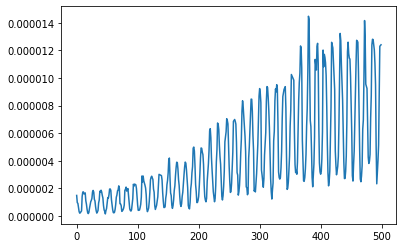

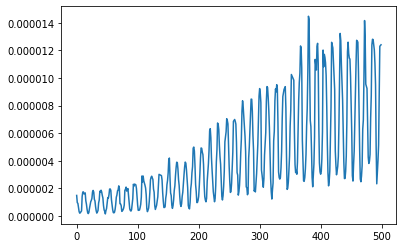

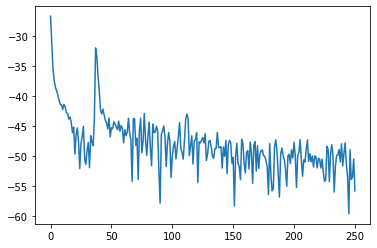

In [23]:
# Import needed modules:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Define needed functions:
def power_unit_converter(power_in_db):
    power_in_mw = 1 * 10 ** (power_in_db * 0.1)
    return power_in_mw

def transformed_unit_converter(linear_value):
    value_in_db = 10 * np.log10(linear_value / 1)
    return value_in_db


# Going to work with the data from the original paper; stored in "Data 2.csv"

# Create an array where I'm going to store all of the data from the .csv file
# This csv file has 1127 entries
data_array = np.zeros([1127, 2])

with open('Data 2.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    line_count = 0
    i = 0 # Just a counting variable
    for row in csv_reader:
        data_array[i, 0] = row[0]
        data_array[i, 1] = row[1]
        i += 1
        
# data_array now contains the data from the plot
# Can plot this:
plt.plot(data_array[:,0], data_array[:, 1])
plt.show()

# Before we do anything else to the data, we should do the linear interpolation step.
x = data_array[:,0]
y = data_array[:,1]
f = interp1d(x,y)

xnew = np.linspace(data_array[:,0][0], data_array[:,0][-1], 500)
inter_data = f(xnew)
plt.plot(x, y, 'r', xnew, inter_data, 'b')
plt.show()

new_data = np.zeros((len(xnew), 2))
new_data[:,0] = xnew
new_data[:,1] = inter_data
print(new_data)
# The paper says that they're taking the FFT with respect to FREQUENCY, not wavelength
# This means that I'll need to convert this data into being in terms of frequency, somehow.
# Presumably, I can just convert from wavelength to frequency using the speed of light.
# I'm assuming that the wavelengths given are vacuum wavelengths.
c = 299792458 # m/s
wavelengths = new_data[:,0] * (1e-9)
frequencies = np.zeros(wavelengths.shape)
for i in range(0, len(wavelengths)):
    frequencies[i] = c / (wavelengths[i])

data_db_freq_array = np.zeros([len(frequencies), 2])
data_db_freq_array[:, 0] = frequencies[::-1]
data_db_freq_array[:, 1] = new_data[:,1][::-1]


# Converting the power values from dBm (assuming that dB means dBm, which seems to be a fairly common convention) to mW:
data_mw_freq_array = np.zeros([len(frequencies), 2])
data_mw_freq_array[:, 0] = frequencies[::-1]

for i in range(0, len(frequencies)):
    power_in_db = data_db_freq_array[i, 1]
    power_in_mw = power_unit_converter(power_in_db)
    data_mw_freq_array[i, 1] = power_in_mw

plt.plot(data_mw_freq_array[:,1])
plt.show()

data_for_fft = data_mw_freq_array[:,1]

plt.plot(data_for_fft)
plt.show()

# Let's try running this through a FFT and see what happens:
transformed_data = np.fft.rfft(data_for_fft)
abs_transformed_data = np.abs(transformed_data)

# Going to try to convert this back from mW (well, mW/s because of the FT I guess...) to decibels
db_abs_transformed_data = np.zeros(len(abs_transformed_data))
for i in range(0, len(abs_transformed_data)):
    linear_value = abs_transformed_data[i]
    value_in_db = transformed_unit_converter(linear_value)
    db_abs_transformed_data[i] = value_in_db

plt.plot(db_abs_transformed_data[:])
plt.show()